Script to calculate growth rates of fish during winter and summer

In [1]:
import xarray as xr
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("default")
import os

warnings.simplefilter("ignore")  # filter some warning messages
sns.axes_style("whitegrid")

import datetime
import logging

import xarray as xr
import matplotlib as mpl
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import global_land_mask
import xesmf as xe
import iris
import CMIP6_downscale_iris

import sys
from dateutil.relativedelta import relativedelta
from cartopy.util import add_cyclic_point
from CMIP6_model import CMIP6_MODEL
import CMIP6_IO
import pyproj

pyproj.datadir.set_data_dir("/Users/trondkr/anaconda3/envs/gcs2/share/proj")
pyproj.datadir.get_data_dir()

'/home/sam/miniconda3/envs/actea-3.9/share/proj'

In [2]:
# Global variables
par_threshold = 0.0368
depth = 5  # meter
attenuation = 0.18

In [3]:
def convert_to_180(ds):
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,lat,lon)
    """

    # Use add_cyclic_point to interpolate input data
    lon_idx = 2  # da.dims.index('lon')

    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(
        data=wrap_data,
        coords={"time": da.time, "lat": da.lat, "lon": wrap_lon},
        dims=da.dims,
        attrs=da.attrs,
    )

    return outp_da


def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)

    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)

    return xr.DataArray(mask_data, coords={"lat": lat, "lon": lon}, dims=["lat", "lon"])


def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)


def get_LME_records_plot():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)


def create_colors(N):
    color = iter(cm.tab20b(np.linspace(0, 1, N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds, var_name, LME, create_maps):
    # Extract the polygon defining the boundaries of the LME
    print(f"Working on LME: {LME}")

    if LME == "Northern Bering - Chukchi Seas":
        shdf = get_LME_records_plot()
    elif LME == "Barents Sea":
        shdf = get_LME_records()
    else:
        raise Exception(f"Unable to parse LME {LME}")

    shdf_sel = shdf[shdf["LME_NAME"] == LME]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    ds = ds.rename({"x": "lon", "y": "lat"})
    ds = ds.rio.write_crs(4326)

    ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326, inplace=True)

    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"})
    return clipped


def create_LME_figure(ax, LMES, projection, show, extent, data_to_contour=None):
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb = create_colors(len(LMES))
    counter = 0
    for LME_NAME, LME_NUMBER in zip(shdf["LME_NAME"], shdf["LME_NUMBER"]):
        shdf_sel = shdf[shdf["LME_NAME"] == LME_NAME]

        if LME_NAME in LMES:
            # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES) == 1:
                color = "red"
            else:
                color = colors_rgb[counter]
            ax.add_geometries(
                shdf_sel["geometry"],
                projection,
                facecolor=color,
                edgecolor="k",
                zorder=8,
            )
            if data_to_contour is not None:
                ax.contourf(
                    data_to_contour.lon,
                    data_to_contour.lat,
                    data_to_contour,
                    zorder=10,
                    cmap=sns.color_palette("Spectral_r", as_cmap=True),
                    transform=ccrs.PlateCarree(),
                )

            # Add the label LME_NUMBER of the selected LME at the center of the LME
            #  ax.annotate(s=LME_NUMBER,
            #              xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
            #              color="white",
            #              fontsize=13)
            counter += 1
        else:
            ax.add_geometries(
                shdf_sel["geometry"], projection, facecolor="LightGray", edgecolor="k"
            )

    if show:
        plotfile = "Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200, bbox_inches="tight")
        plt.show()


def get_data_within_LME(ds, var_name, LME, create_maps, scenario):
    print(
        "Extracting data within LME {} for {} scenario {}".format(
            LME, var_name, scenario
        )
    )

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[shdf["LME_NAME"] == LME]

    # Create the map of the LME boundaries and color it.
    # The active LME has color while the others are grey.
    if create_maps:
        # Setup the figure panels
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea", "Arctic Ocean"]:
            projection = (
                ccrs.NorthPolarStereo()
            )  # ccrs.PlateCarree(central_longitude=0)
            extent = [-8, 80, 67, 90]
        else:
            projection = ccrs.PlateCarree(central_longitude=-180)
            extent = [-252, -100, 10, 65]
            extent = [-220, -135, 30, 85]
        ax1 = fig.add_subplot(111, projection=projection)

        create_LME_figure(
            ax1, [LME], ccrs.PlateCarree(central_longitude=-180), True, extent
        )

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos = ds.rename({"lon": "x", "lat": "y"})
    tos = tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped = clipped.rename({"x": "lon", "y": "lat"})  # .to_dataset()

    return clipped


def get_formatted_ds_within_LME(ds, var_name, LME, scenario):
    if var_name in ["tos_mean", "siconc_mean"]:
        ds = ds.assign_coords(lat=ds.y, lon=ds.x)
        ds = ds.rename({"x": "lon", "y": "lat"})
    ds = convert_to_180(ds)
    ds = convert_time(ds)

    ds_lme = get_data_within_LME(ds, var_name, LME, False, scenario)
    ds_lme = xr_add_cyclic_point(ds_lme[var_name])
    ds_lme = ds_lme.to_dataset(name=var_name)

    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme.isel(time=0))
    return ds_lme.where(ds_lme.mask == 1)


def calculate_daily_uvb_exposure_and_combine_datasets(ds, ds_uvb, ds_par):
    # Sum up the four UVB values per day to get daily exposure (kJm-2)
    ds[uvb_var] = (ds_uvb[uvb_var] * 3600 * 4.0) / 1000.0
    ds[par_var] = ds_par[par_var]

    return ds.resample(time="MS", skipna=True).sum()


def calculate_egg_survival(T, specie):
    if specie == "pacific_cod":
        # Laurel et al., 2020
        H = (0.453 / (1 + ((T - 4.192) / 2.125) ** 2)) * 100
    elif specie == "atlantic_cod":
        # Dahlke et al., 2018
        H = -318027.1388 + (318119.8195 / (1 + ((T - 4.337) / 467.4799) ** 2))
    elif specie == "polar_cod":
        # Laurel et al., 2018
        H = 87.926 + 1.266 * T - 3.6582 * T**2
    elif specie == "walleye_pollock":
        # Laurel et al., 2018
        H = 72.127 + 5.775 * T - 0.801 * T**2
    H = xr.where(H < 0, 0.0, H)
    return H


def egg_survival(ds: xr.Dataset, var_name: str, species: str):
    """Calculate egg survival in surface for different species in percentage given
    temperature of water column"""

    ds["par_mean"] = ds["par_mean"] * np.exp(-depth * attenuation)
    ds["areacello_par_masked"] = xr.where(
        ds["par_mean"] >= par_threshold, ds["areacello"], np.nan
    )
    ds["tos_mean_par_masked"] = xr.where(
        ds["par_mean"] >= par_threshold, ds["tos_mean"], np.nan
    )

    for specie in species:
        print("Calculating survival for {}".format(specie))
        T = ds["tos_mean"]
        H = calculate_egg_survival(T, specie)

        ds["{}_egg_par_masked".format(specie)] = (("time", "lat", "lon"), H.data)
    return ds


def calculate_areacello(ds, model_obj, var_name, project_name):
    # Calculate the area based on the longitude - latitude
    if ds.lon.ndim == 2:
        lon = ds.lon.values[0, :]
        lat = ds.lat.values[:, 0]
    else:
        lon = ds.lon.values
        lat = ds.lat.values

    ds_singletime = ds.isel(time=0)

    # Convert the dataset to a cube as this adds correct units required by iris
    sdiris = CMIP6_downscale_iris.CMIP6_downscale_iris()
    cube = sdiris.ds_to_iris(
        ds_singletime, var_name, model_obj, project_name, prefix="cube"
    )

    # Calculate the areacello for the grid and convert the result to km2
    # Uses iris area_weights function.
    # https://scitools.org.uk/iris/docs/v2.4.0/iris/iris/analysis/cartography.html#iris.analysis.cartography.area_weights
    m2_to_km2 = 1.0e-6
    area_ends = (
        iris.analysis.cartography.area_weights(cube, normalize=False)
    ) * m2_to_km2

    # Now convert the numpy array of areas to a dataset with the same dimension as the siconc
    area_ds = xr.DataArray(
        name="areacello",
        data=area_ends,
        coords={"lat": lat, "lon": lon},
        dims=["lat", "lon"],
    ).to_dataset()

    # Convert the resulting dataset to an iris cube
    area_cube = sdiris.ds_to_iris(
        area_ds, "areacello", model_obj, project_name, prefix="areacello_"
    )

    # Fix the coordinates so that we add geographic information to the cube,
    # before saving the cube to the siconc dataset
    area_cube = sdiris.fix_coordinates_cube(area_cube / 1.0e6)

    return xr.DataArray.from_iris(area_cube)


def calculate_juvenile_growth(T, specie):
    if specie == "atlantic_cod":
        # Bjørnsson et al., 2007
        G = -0.2425 + 0.1519 * T + 0.0552 * T**2 - 0.002931 * T**3

    elif specie == "polar_cod":
        # Laurel et al., 2016
        G = 0.8290 + 0.1638 * T - 0.0054 * T**2 - 0.0005 * T**3

    elif specie == "pacific_cod":
        G = 0.2494 + 0.3216 * T - 0.0069 * T**2 - 0.0004 * T**3

    elif specie == "walleye_pollock":
        G = 0.2023 + 0.0992 * T + 0.0335 * T**2 - 0.0019 * T**3
    return G


def cumulative_juvenile_growth_potential(ds: xr.Dataset, var_name: str, species: str):
    """Calculate larval survival in surface for different species in percentage given
    temperature of water column"""

    ds_daily = ds.resample(time="1D", skipna=True).interpolate("linear")
    ds_daily["par_mean"] = ds_daily["par_mean"] * np.exp(-depth * attenuation)

    ds_daily["tos_mean"] = xr.where(
        ds_daily["par_mean"] >= par_threshold, ds_daily["tos_mean"], np.nan
    )
    ds_daily["areacello_par_masked"] = xr.where(
        ds_daily["par_mean"] >= par_threshold, ds_daily["areacello"], np.nan
    )
    ds_daily["tos_mean_par_masked"] = xr.where(
        ds_daily["par_mean"] >= par_threshold, ds_daily["tos_mean"], np.nan
    )

    ds_daily = ds_daily.transpose("time", "lat", "lon")

    print(
        "total sum 1 : {}".format(
            ds_daily["tos_mean"].count(dim=["lat", "lon"]).sum().values
        )
    )
    print(
        "total sum 2 : {}".format(
            ds_daily["tos_mean_par_masked"].count(dim=["lat", "lon"]).sum().values
        )
    )

    for specie in species:
        print("Calculating growth potential for {}".format(specie))
        T = ds_daily[var_name]
        T_par = ds_daily["tos_mean_par_masked"]

        G = calculate_juvenile_growth(T, specie)
        G_par = calculate_juvenile_growth(T_par, specie)

        ds_daily["{}_juvenile".format(specie)] = (("time", "lat", "lon"), G.data)
        ds_daily["{}_juvenile_par_masked".format(specie)] = (
            ("time", "lat", "lon"),
            G_par.data,
        )

    return ds_daily.resample(time="MS", skipna=True).mean()


def calculate_combined_uvb_scaled_survival_and_combine_datasets(
    ds: xr.Dataset,
    ds_uvb_lme: xr.Dataset,
    ds_sic_lme: xr.Dataset,
    ds_par_lme: xr.Dataset,
    species: str,
    seaice_minimum: int,
):
    regridder = xe.Regridder(
        ds_uvb_lme,
        ds,
        "bilinear",
        periodic=False,
        extrap_method="inverse_dist",
        extrap_num_src_pnts=2,
        extrap_dist_exponent=1,
        ignore_degenerate=True,
    )

    regridder_sic = xe.Regridder(
        ds_sic_lme,
        ds,
        "bilinear",
        periodic=False,
        extrap_method="inverse_dist",
        extrap_num_src_pnts=2,
        extrap_dist_exponent=1,
        ignore_degenerate=True,
    )

    ds[uvb_var] = (("time", "lat", "lon"), regridder(ds_uvb_lme[uvb_var]).data)
    ds[par_var] = (("time", "lat", "lon"), regridder(ds_par_lme[par_var]).data)
    ds["siconc_mean"] = (
        ("time", "lat", "lon"),
        regridder_sic(ds_sic_lme["siconc_mean"]).data,
    )

    """
    Filter out only areas where minimum light threshold is adequate for feeding. any other regions will
    not satisfy survival for larval stages.
    """
    ds[uvb_var] = xr.where(ds["par_mean"] >= par_threshold, ds[uvb_var], np.nan)
    ds[par_var] = xr.where(ds["par_mean"] >= par_threshold, ds[par_var], np.nan)

    """
    Calculate the monthly relative change in uvb light for the LMe and provide as timeseries
    """
    clim_uvb = (
        ds[uvb_var]
        .sel(time=(slice("1980-01-01", "2000-12-31")))
        .groupby("time.month")
        .mean(dim="time")
    )
    clim_par = (
        ds[par_var]
        .sel(time=(slice("1980-01-01", "2000-12-31")))
        .groupby("time.month")
        .mean(dim="time")
    )

    ds["uvb_ice"] = (ds[uvb_var].groupby("time.month") - clim_uvb) / clim_uvb.max(
        dim="month"
    )
    ds["par_ice"] = (ds[par_var].groupby("time.month") - clim_par) / clim_par.max(
        dim="month"
    )

    # xr.where(((ds["siconc_mean"] > seaice_minimum) ), ds[uvb_var], np.nan)
    # ds["uvb_ice"]=xr.where(((np.isnan(ds["siconc_mean"]) | (ds["siconc_mean"] == 0.0))), ds["uvb_ice"], np.nan)
    # ds["par_ice"]=xr.where(((np.isnan(ds["siconc_mean"]) | (ds["siconc_mean"] == 0.0))), ds["par_ice"], np.nan)

    return ds


def q5(x):
    return x.quantile(0.05)


def q95(x):
    return x.quantile(0.95)


def plot_averaged_growth_or_survival(
    df: pd.DataFrame,
    df_survival: pd.DataFrame,
    specie: str,
    rolling_mean_years: int,
    egg_or_larva: str,
    LME: str,
    dfs_all_seasons,
    season,
):
    # This plotting method takes the SSP245 and SSP585 dataframe for survival/growth, temperature,
    # and uvb light and plots each of these variables. Dataframe is in monthly values but an aggregator
    # function calculates the annual average mean and quantiles within each year fulfilling the months requirement.
    # For larval and juvenile stages we consider only the summer months e.g. months=[5,6,7,8]

    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
    f = plt.figure(figsize=(12, 6))
    f.clf()

    gs = f.add_gridspec(1, 3)
    ax = f.add_subplot(gs[0, 0])
    ax2 = f.add_subplot(gs[0, 1])
    ax3 = f.add_subplot(gs[0, 2])

    sns.set_palette("tab10")

    # Organize the data for dataframe survival --------
    df_survival["time_bin"] = pd.to_datetime(df_survival.time)
    bins = np.arange(1979, 2100, 1)

    dfs245 = df_survival[df_survival["scenario"] == "ssp245"]
    dfs585 = df_survival[df_survival["scenario"] == "ssp585"]

    # Growth or survival in areas adequate for feeding
    dfs245["time_bin"] = pd.cut(dfs245.time_bin.dt.year, bins, right=False)
    if egg_or_larva == "egg":
        specie_var = "{}_egg_par_masked".format(specie)
    else:
        specie_var = "{}_juvenile_par_masked".format(specie)

    dfgs245 = dfs245.groupby("time_bin", as_index=False)[specie_var].agg(
        [q5, q95, "mean"]
    )
    dfgs245["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    dfs585["time_bin"] = pd.cut(dfs585.time_bin.dt.year, bins, right=False)
    dfgs585 = dfs585.groupby("time_bin", as_index=False)[specie_var].agg(
        [q5, q95, "mean"]
    )
    dfgs585["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    # Areacello where PAR above threshold for feeding
    if egg_or_larva == "egg":
        sel_var = "siconc_mean"
    else:
        sel_var = "areacello_par_masked"

    dftos245 = dfs245.groupby("time_bin", as_index=False)["tos_mean"].agg(
        [q5, q95, "mean"]
    )
    dftos245["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    dftos585 = dfs585.groupby("time_bin", as_index=False)["tos_mean"].agg(
        [q5, q95, "mean"]
    )
    dftos585["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    # Ocean UVB under ice - not used as very small values
    dfarea_or_ice245 = dfs245.groupby("time_bin", as_index=False)[sel_var].agg(
        [q5, q95, "mean"]
    )
    dfarea_or_ice245["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    dfarea_or_ice585 = dfs585.groupby("time_bin", as_index=False)[sel_var].agg(
        [q5, q95, "mean"]
    )
    dfarea_or_ice585["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    alpha = 0.2
    tickfontsize = 22

    # SSP245 growth/survival
    ax3.fill_between(
        dfgs245["proper_time"],
        dfgs245["q5"].rolling(rolling_mean_years).mean(),
        dfgs245["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:blue",
    )

    ax3.plot(
        dfgs245["proper_time"],
        dfgs245["mean"].rolling(rolling_mean_years).mean(),
        color="tab:blue",
        alpha=1.0,
        linewidth=4,
    )

    # SSP585 growth/survival
    ax3.fill_between(
        dfgs585["proper_time"],
        dfgs585["q5"].rolling(rolling_mean_years).mean(),
        dfgs585["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:orange",
    )

    ax3.plot(
        dfgs585["proper_time"],
        dfgs585["mean"].rolling(rolling_mean_years).mean(),
        color="tab:orange",
        alpha=1.0,
        linewidth=4,
    )

    # SSP245 ocean temperature
    ax.fill_between(
        dftos245["proper_time"],
        dftos245["q5"].rolling(rolling_mean_years).mean(),
        dftos245["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:blue",
    )

    ax.plot(
        dftos245["proper_time"],
        dftos245["mean"].rolling(rolling_mean_years).mean(),
        #    linestyle="--",
        color="tab:blue",
        alpha=1.0,
        linewidth=4,
    )

    # SSP585 TOS

    ax.fill_between(
        dftos585["proper_time"],
        dftos585["q5"].rolling(rolling_mean_years).mean(),
        dftos585["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:orange",
    )

    ax.plot(
        dfgs585["proper_time"],
        dftos585["mean"].rolling(rolling_mean_years).mean(),
        # linestyle="--",
        color="tab:orange",
        alpha=1.0,
        linewidth=4,
    )

    ylabels = ["{:,.2f}{}".format(y, "$^{o}C$") for y in ax.get_yticks()]
    ax.set_yticklabels(ylabels)

    #    ylabels = ['{:.0e}{}'.format(y,u"\N{DEGREE SIGN}C") for y in ax3.get_yticks()]
    #  if egg_or_larva== "egg":
    #    ylabels = ['{:,.2f}{}'.format(y,u"\N{DEGREE SIGN}C") for y in ax3.get_yticks()]
    # else:
    #     ylabels = ['{:,.0f}{}'.format(y,u"km$^{2}$") for y in ax3.get_yticks()]
    # ax3.set_yticklabels(ylabels)
    plt.legend(loc="upper right", frameon=False, fontsize=24)

    # https://reckoningrisk.com/watercolor-regression/
    df["time_bin"] = pd.to_datetime(df.time)
    df245 = df[df["scenario"] == "ssp245"]
    df585 = df[df["scenario"] == "ssp585"]

    # Plot PAR for the selected months
    df245["time_bin"] = pd.cut(df245.time_bin.dt.year, bins, right=False)
    dfg245 = df245.groupby("time_bin", as_index=False)["par_ice"].agg([q5, q95, "mean"])
    dfg245["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    df585["time_bin"] = pd.cut(df585.time_bin.dt.year, bins, right=False)
    dfg585 = df585.groupby("time_bin", as_index=False)["par_ice"].agg([q5, q95, "mean"])
    dfg585["proper_time"] = [
        datetime.datetime(1980, 6, 15) + relativedelta(years=i) for i in range(0, 120)
    ]

    ax2.fill_between(
        dfarea_or_ice245["proper_time"],
        dfarea_or_ice245["q5"].rolling(rolling_mean_years).mean(),
        dfarea_or_ice245["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:blue",
    )

    ax2.plot(
        dfarea_or_ice245["proper_time"],
        dfarea_or_ice245["mean"].rolling(rolling_mean_years).mean(),
        color="tab:blue",
        alpha=1.0,
        linewidth=4,
    )

    ax2.fill_between(
        dfarea_or_ice585["proper_time"],
        dfarea_or_ice585["q5"].rolling(rolling_mean_years).mean(),
        dfarea_or_ice585["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:orange",
    )

    ax2.plot(
        dfarea_or_ice585["proper_time"],
        dfarea_or_ice585["mean"].rolling(rolling_mean_years).mean(),
        color="tab:orange",
        alpha=1.0,
        linewidth=4,
    )

    ax2.tick_params(labelsize=tickfontsize)
    ax2.set_ylabel("")  # "kJm$^{-2}$", fontsize=24)
    if sel_var == "siconc_mean":
        ylabels = ["{:,.1f}{}".format(y, "%") for y in ax2.get_yticks()]
    else:
        ylabels = ["{:,.2f}{}".format(y, "") for y in ax2.get_yticks()]

    ax2.set_yticklabels(ylabels)
    f.canvas.draw()

    # Before you can edit and rotate the labels you have to draw them
    plt.draw()
    ylabels = ["{:,.1f}{}".format(y, "%") for y in ax3.get_yticks()]
    ax3.set_yticklabels(ylabels)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=-90, ha="right", fontsize=16)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=-90, ha="right", fontsize=16)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=-90, ha="right", fontsize=16)
    ax.tick_params(labelsize=tickfontsize)
    ax3.tick_params(labelsize=tickfontsize)
    ax2.tick_params(labelsize=tickfontsize)

    if not os.path.exists("Figures"):
        os.makedirs("Figures")
    plotfile = "Figures/{}_uvb_{}_{}.png".format(egg_or_larva, LME, specie)
    print("Created figure {}".format(plotfile))
    gs.tight_layout(f)

    plt.savefig(plotfile, dpi=300, bbox_inches="tight")
    plt.show()

    # Store the growth and survival data
    print(f"Saving data to dictionary: {egg_or_larva}_{season}_{specie}_ssp245_{LME}")
    dfs_all_seasons[f"{egg_or_larva}_{season}_{specie}_ssp245_{LME}"] = dfgs245
    dfs_all_seasons[f"{egg_or_larva}_{season}_{specie}_ssp585_{LME}"] = dfgs585

    return dfs_all_seasons

[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_tos_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_siconc_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
Extracting data within LME Barents Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Averag

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/egg_uvb_Barents Sea_polar_cod.png


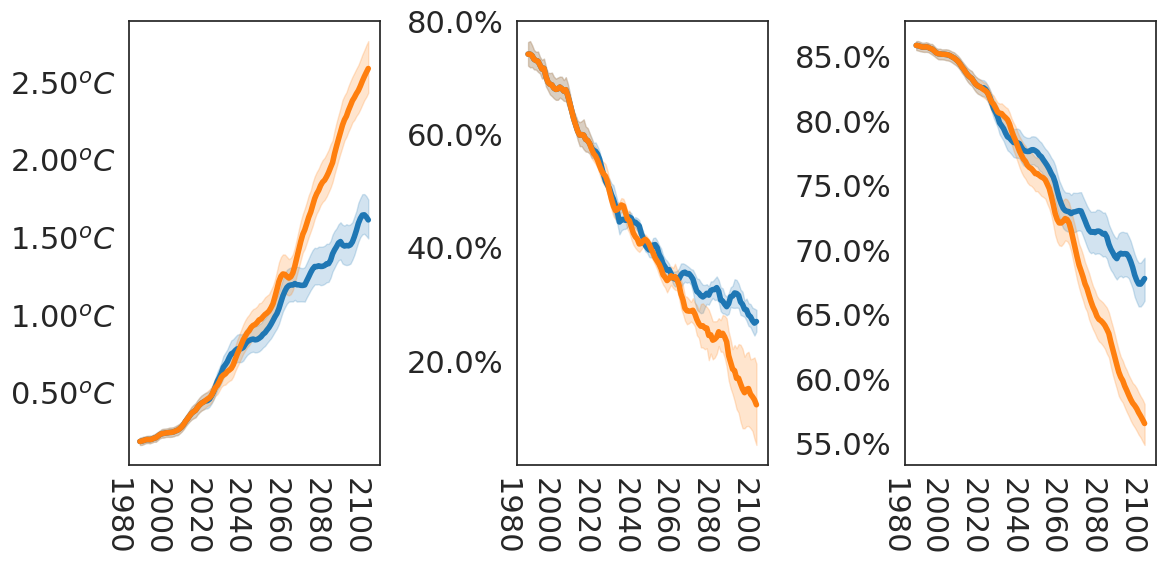

Saving data to dictionary: egg_winter_polar_cod_ssp245_Barents Sea


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/egg_uvb_Barents Sea_atlantic_cod.png


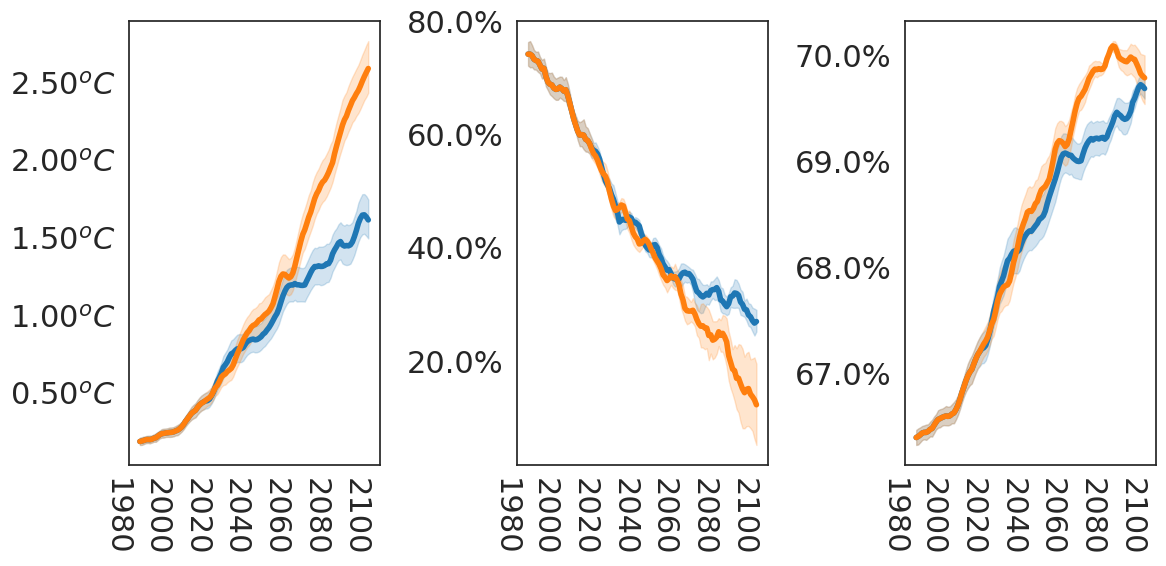

Saving data to dictionary: egg_winter_atlantic_cod_ssp245_Barents Sea
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_tos_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_siconc_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scenario s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/egg_uvb_Northern Bering - Chukchi Seas_polar_cod.png


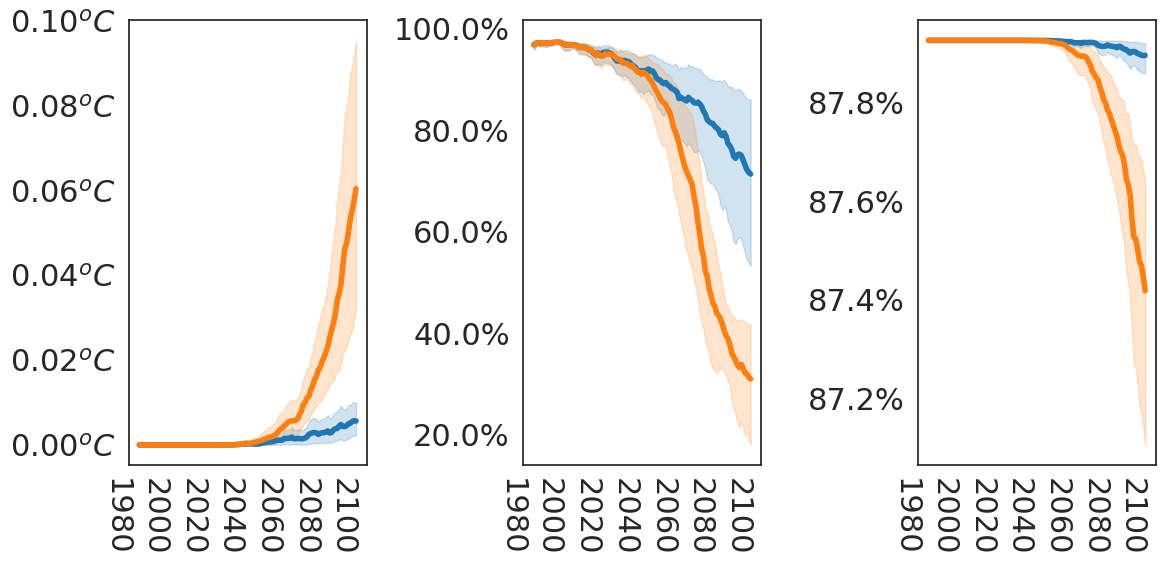

Saving data to dictionary: egg_winter_polar_cod_ssp245_Northern Bering - Chukchi Seas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/egg_uvb_Northern Bering - Chukchi Seas_walleye_pollock.png


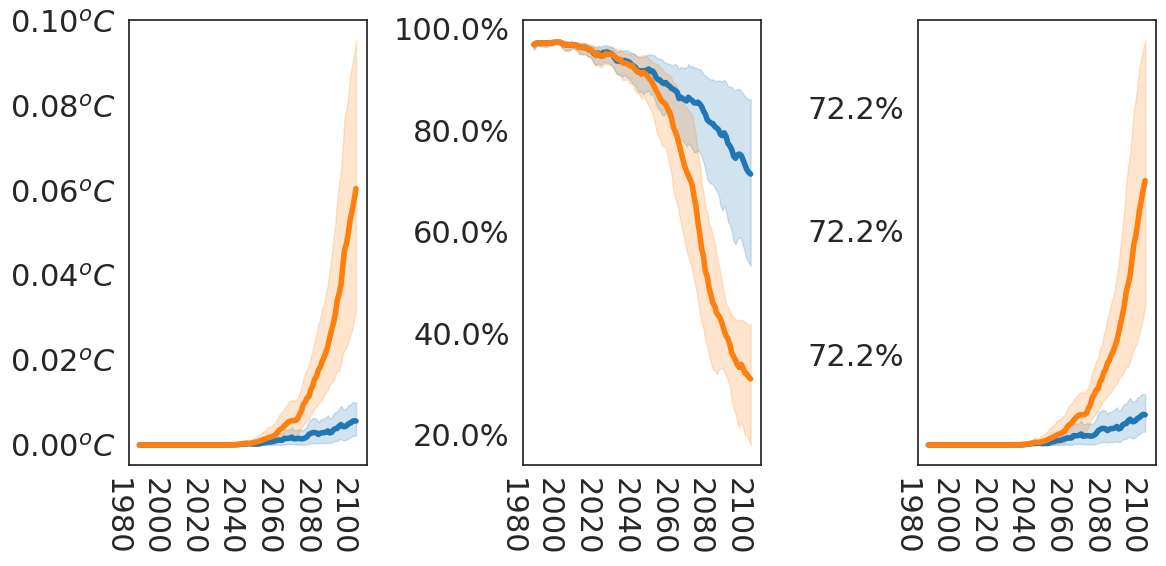

Saving data to dictionary: egg_winter_walleye_pollock_ssp245_Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_tos_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_siconc_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
Extracting data within LME Barents Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_oce

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/juvenile_uvb_Barents Sea_polar_cod.png


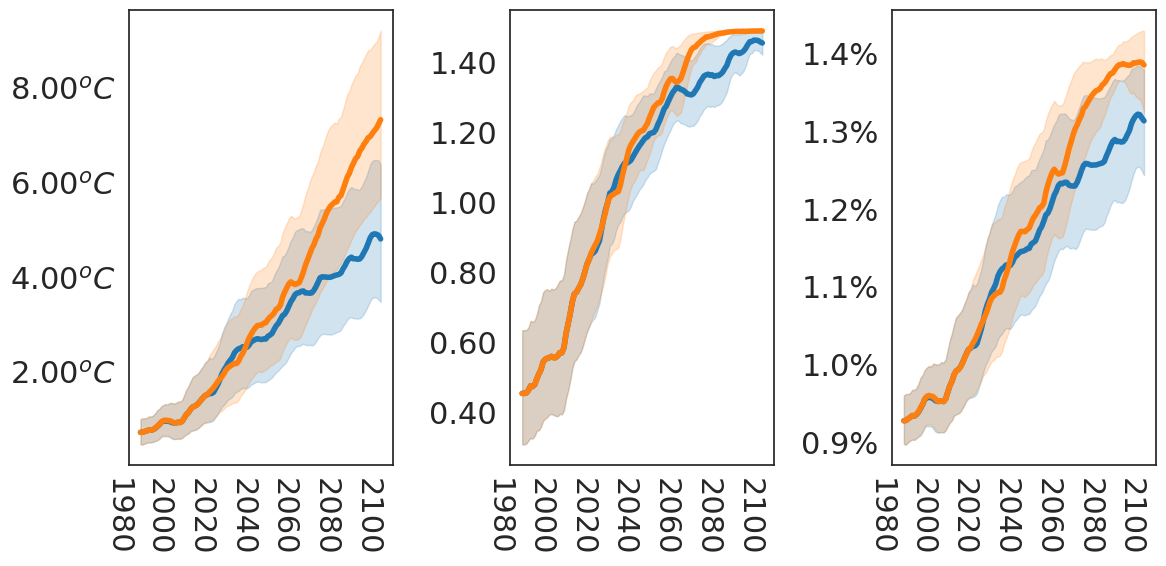

Saving data to dictionary: juvenile_spring_polar_cod_ssp245_Barents Sea


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/juvenile_uvb_Barents Sea_atlantic_cod.png


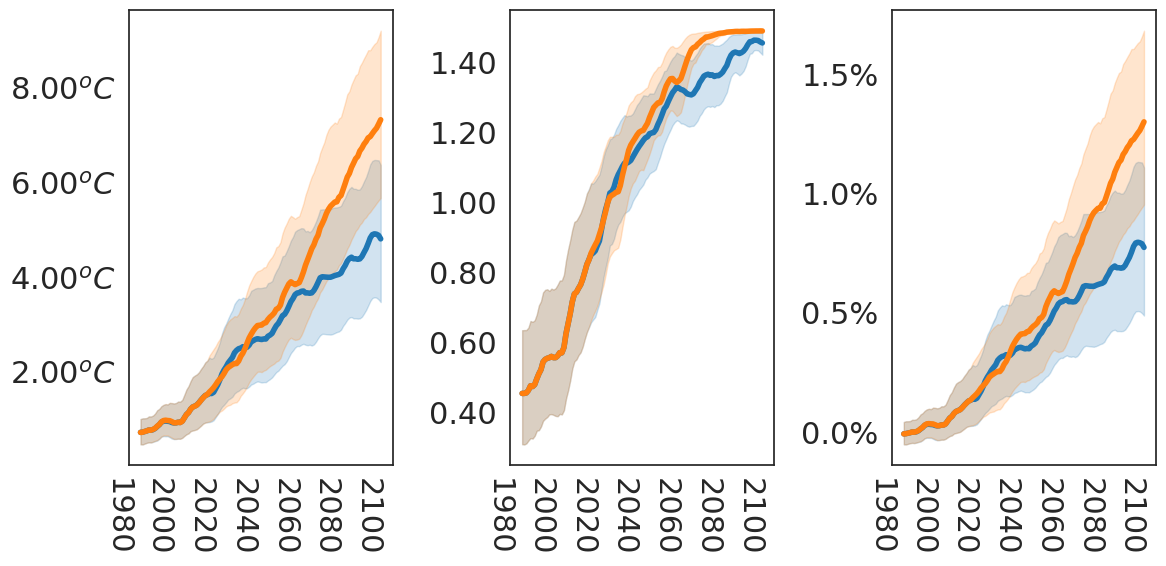

Saving data to dictionary: juvenile_spring_atlantic_cod_ssp245_Barents Sea
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_tos_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_siconc_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb_weighted.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scena

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/juvenile_uvb_Northern Bering - Chukchi Seas_polar_cod.png


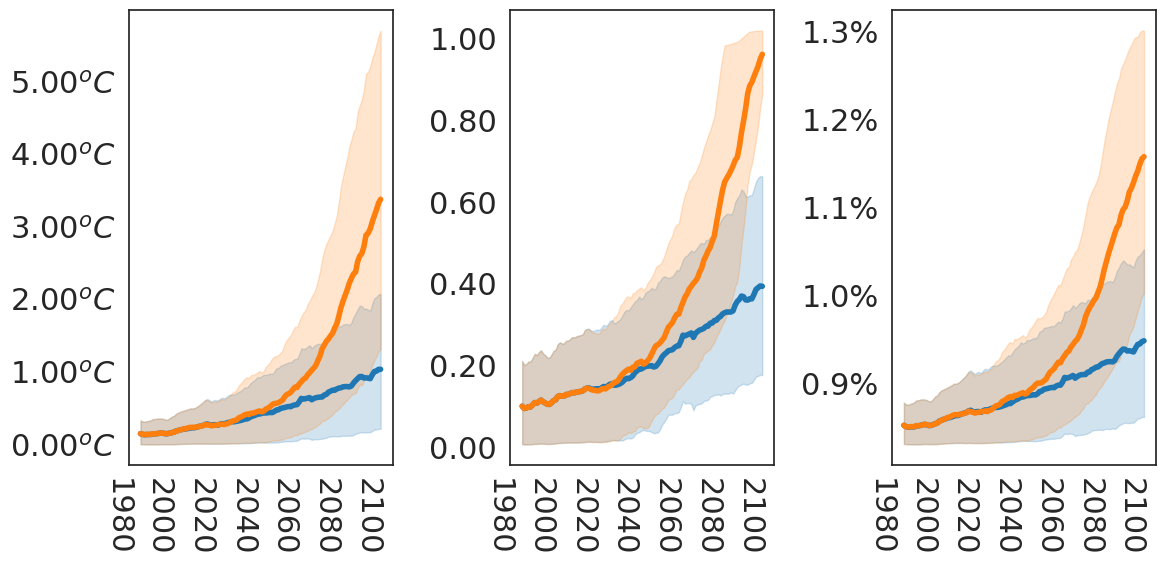

Saving data to dictionary: juvenile_spring_polar_cod_ssp245_Northern Bering - Chukchi Seas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created figure Figures/juvenile_uvb_Northern Bering - Chukchi Seas_walleye_pollock.png


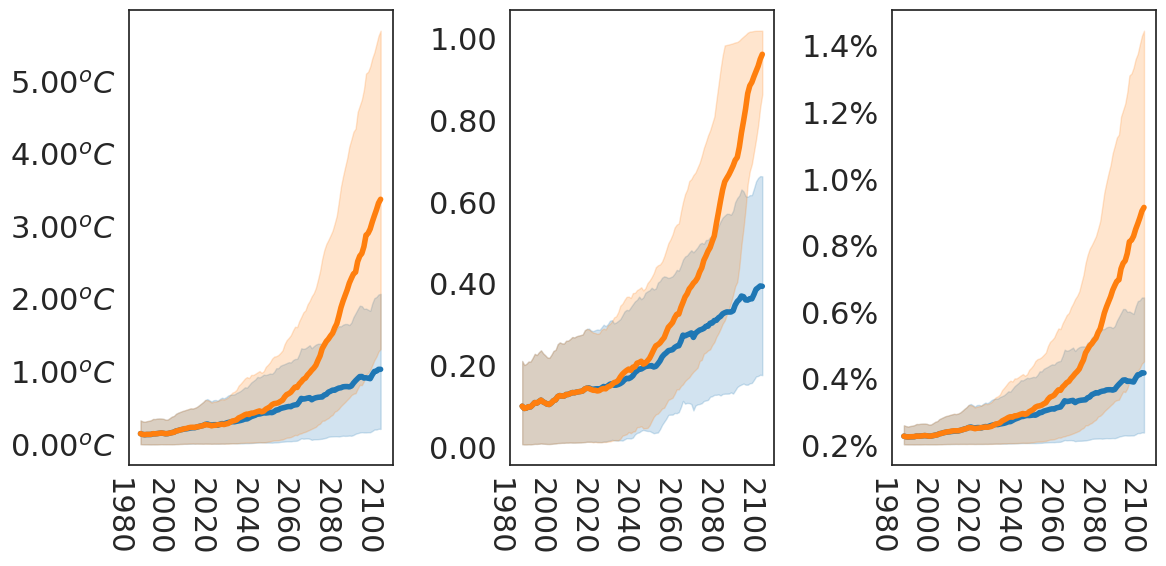

Saving data to dictionary: juvenile_spring_walleye_pollock_ssp245_Northern Bering - Chukchi Seas
{'egg_winter_polar_cod_ssp245_Barents Sea':                      q5        q95       mean proper_time
time_bin                                                 
[1979, 1980)  85.703707  86.254756  85.997879  1980-06-15
[1980, 1981)  85.646640  86.396808  86.035766  1981-06-15
[1981, 1982)  85.513028  86.217568  85.884062  1982-06-15
[1982, 1983)  85.398216  86.186275  85.799042  1983-06-15
[1983, 1984)  85.343556  85.995032  85.672921  1984-06-15
...                 ...        ...        ...         ...
[2094, 2095)  65.683906  69.007432  67.343379  2095-06-15
[2095, 2096)  65.663615  69.159381  67.496840  2096-06-15
[2096, 2097)  66.109128  69.504277  67.859571  2097-06-15
[2097, 2098)  66.482248  69.613234  68.125605  2098-06-15
[2098, 2099)  66.568261  69.847315  68.232290  2099-06-15

[120 rows x 4 columns], 'egg_winter_polar_cod_ssp585_Barents Sea':                      q5        q95   

In [4]:
LMES = ["Barents Sea", "Northern Bering - Chukchi Seas"]  # ,'Central Arctic']

SPECIES_PER_LME = [["polar_cod", "atlantic_cod"], ["polar_cod", "walleye_pollock"]]

create_ensemble = True
scenarios = ["ssp245", "ssp585"]
var_names = ["par_"]  # "uv_","uvi_","par_", "uvb_","_tos.nc","_siconc.nc"]

start_time = "1979-01-01"
end_time = "2099-12-16"
spring_months = [4, 5, 6]
winter_months = [1, 2, 3]

rolling_mean_years = 5
seaice_minimum = 15
dfs_all_seasons = {}

for months in [winter_months, spring_months]:
    for LME, species in zip(LMES, SPECIES_PER_LME):
        if months == winter_months:
            season = "winter"
        else:
            season = "spring"

        if LME in ["Barents Sea", "Arctic Ocean"]:
            projection = ccrs.NorthPolarStereo()
            extent = [-10, 80, 67, 85]
        else:
            projection = ccrs.PlateCarree(central_longitude=-180)
            extent = [-200, -145, 50, 85]

        dfs = []
        dfs_survival = []
        uvb_var = "uvb_mean"
        par_var = "par_mean"

        for scenario in scenarios:
            ensemble_path = "light/ncfiles/ensemble"
            lightpath = f"light/{scenario}/ensemble"

            io = CMIP6_IO.CMIP6_IO()
            tos = io.open_dataset_on_gs(
                f"{lightpath}/CMIP6_ensemble_stats_{scenario}_tos_weighted.nc"
            )
            sic = io.open_dataset_on_gs(
                f"{lightpath}/CMIP6_ensemble_stats_{scenario}_siconc_weighted.nc"
            )
            uvb = io.open_dataset_on_gs(
                f"{ensemble_path}/CMIP6_ensemble_stats_{scenario}_uvb_weighted.nc"
            )
            par = io.open_dataset_on_gs(
                f"{ensemble_path}/CMIP6_ensemble_stats_{scenario}_par_weighted.nc"
            )

            par = par.sel(time=slice(start_time, end_time))
            tos = tos.sel(time=slice(start_time, end_time))
            uvb = uvb.sel(time=slice(start_time, end_time))
            sic = sic.sel(time=slice(start_time, end_time))

            ds_uvb_lme = get_formatted_ds_within_LME(uvb, uvb_var, LME, scenario)
            ds_par_lme = get_formatted_ds_within_LME(par, par_var, LME, scenario)
            ds_sic_lme = (
                get_formatted_ds_within_LME(sic, "siconc_mean", LME, scenario)
                .resample(time="MS", skipna=True)
                .mean()
            )
            ds_tos_lme = (
                get_formatted_ds_within_LME(tos, "tos_mean", LME, scenario)
                .resample(time="MS", skipna=True)
                .mean()
            )

            ds_sic_lme = xr.where(ds_sic_lme <= 0, np.nan, ds_sic_lme)
            ds_tos_lme = xr.where(ds_tos_lme <= -2.0, np.nan, ds_tos_lme)

            ds_tos_lme = xr.where(
                ((ds_tos_lme < 1.0e-20) | (ds_tos_lme > 1e20)), np.nan, ds_tos_lme
            )
            ds_sic_lme = xr.where(
                ((ds_sic_lme < 1.0e-20) | (ds_sic_lme > 1e20)), np.nan, ds_sic_lme
            )
            ds_par_lme = xr.where(
                ((ds_par_lme < 1.0e-20) | (ds_par_lme > 1e20)), np.nan, ds_par_lme
            )
            ds_uvb_lme = xr.where(
                ((ds_uvb_lme < 1.0e-20) | (ds_uvb_lme > 1e20)), np.nan, ds_uvb_lme
            )

            # Select the time period
            ds_uvb_lme = ds_uvb_lme.sel(lat=slice(50, 91))
            ds_par_lme = ds_par_lme.sel(lat=slice(50, 91))
            ds_tos_lme = ds_tos_lme.sel(lat=slice(50, 91))
            ds_sic_lme = ds_sic_lme.sel(lat=slice(50, 91))

            ds_tos_lme["mask"] = create_land_ocean_mask(ds_tos_lme.isel(time=0))
            ds_tos_lme = ds_tos_lme.where(ds_tos_lme.mask == 1)
            model_obj = CMIP6_MODEL("ensemble")

            ds_tos_lme["areacello"] = calculate_areacello(
                ds_tos_lme, model_obj, "tos_mean", project_name="light"
            )
            # Clip the area to the polygon - this also clips to the time varying var_name# which results in
            # time varying areacello variable that we can use to sum up the size of open water by
            # looking at the annual mean.
            # First we set all areas outside of the polygon to nan - which also now includes
            # areacello which as part of teh calculations actually covered the whole region (and
            # not just the polygon).
            ds_tos_lme = xr.where(np.isnan(ds_tos_lme["tos_mean"]), np.nan, ds_tos_lme)
            total_area_lme = np.nansum(ds_tos_lme["areacello"].mean(dim="time").values)
            print(
                "[calculate_areacello] Average total area {:,.2f} km2".format(
                    total_area_lme
                )
            )

            ds_uvb_lme = ds_uvb_lme.resample(time="MS", skipna=True).mean()
            ds_sic_lme = ds_sic_lme.resample(time="MS", skipna=True).mean()
            ds_par_lme = ds_par_lme.resample(time="MS", skipna=True).mean()
            ds_uvb_lme["mask"] = (("lat", "lon"), ds_uvb_lme["mask"].isel(time=0).data)
            ds_sic_lme["mask"] = (("lat", "lon"), ds_sic_lme["mask"].isel(time=0).data)
            ds_par_lme["mask"] = (("lat", "lon"), ds_par_lme["mask"].isel(time=0).data)

            ds = calculate_daily_uvb_exposure_and_combine_datasets(
                ds_tos_lme, ds_uvb_lme, ds_par_lme
            )

            # Light (par, uvb) and forcing (tos, sic) are on slightly different grids. We combine all
            # datasets to a common grid.
            ds["mask"] = create_land_ocean_mask(ds.isel(time=0))

            ds = calculate_combined_uvb_scaled_survival_and_combine_datasets(
                ds, ds_uvb_lme, ds_sic_lme, ds_par_lme, species, seaice_minimum
            )

            # Calculate the survival potential for all species
            if months[0] >= 4:
                larva_or_egg = "juvenile"
                ds = cumulative_juvenile_growth_potential(ds, "tos_mean", species)
            else:
                larva_or_egg = "egg"
                ds = egg_survival(ds, "tos_mean", species)

            # Important to set zeros to nan - the zeroes come after performing resample
            # ds = xr.where(ds <= 0, np.nan, ds)

            ds_avg = ds.sel(time=ds.time.dt.month.isin(months)).mean({"lat", "lon"})

            ds_avg = ds_avg.assign(
                areacello_par_masked=ds["areacello_par_masked"].sum({"lat", "lon"})
            )

            df = ds_avg.to_dataframe()  # .resample("A").mean()
            df_survival = ds_avg.to_dataframe()  # .resample("A").mean()

            df = df.reset_index(level=[0])
            df_survival = df_survival.reset_index(level=[0])

            df["scenario"] = scenario
            df_survival["scenario"] = scenario

            dfs.append(df)
            dfs_survival.append(df_survival)

        # Concatenate all scenarios into one dataframe for this LME
        df_all = pd.concat(dfs)
        df_all_survival = pd.concat(dfs_survival)

        # Plot the results for this LME
        for specie in species:
            dfs_all_seasons = plot_averaged_growth_or_survival(
                df_all,
                df_all_survival,
                specie,
                rolling_mean_years,
                larva_or_egg,
                LME,
                dfs_all_seasons,
                season,
            )
print(dfs_all_seasons)

Maximum for function calculate_juvenile_growth polar_cod - 7.500 growth rate:  1.543
                    q5       q95      mean proper_time
time_bin                                              
[1979, 1980)  0.498528  0.534970  0.516098  1980-06-15
[1980, 1981)  0.495243  0.539193  0.516027  1981-06-15
[1981, 1982)  0.496081  0.533196  0.513991  1982-06-15
[1982, 1983)  0.498299  0.534113  0.516107  1983-06-15
Created figure Figures/habitat_suitability_Barents Sea_polar_cod.png


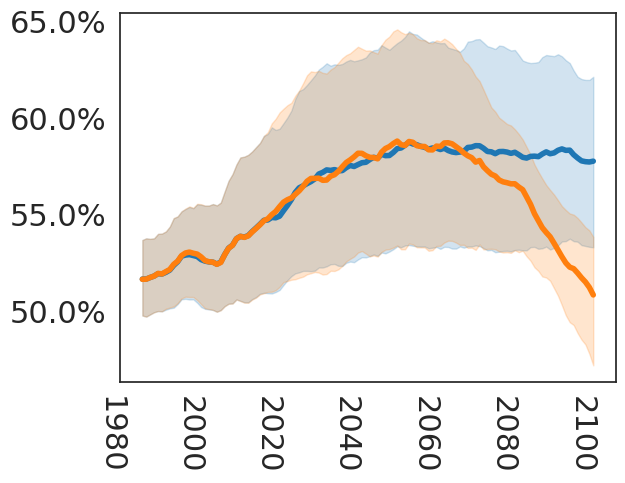

Maximum for function calculate_juvenile_growth atlantic_cod - 13.800 growth rate:  4.663
                    q5       q95      mean proper_time
time_bin                                              
[1979, 1980) -0.014581  0.010059 -0.003010  1980-06-15
[1980, 1981) -0.016054  0.013683 -0.002319  1981-06-15
[1981, 1982) -0.015204  0.011130 -0.002934  1982-06-15
[1982, 1983) -0.013810  0.010149 -0.002251  1983-06-15
Created figure Figures/habitat_suitability_Barents Sea_atlantic_cod.png


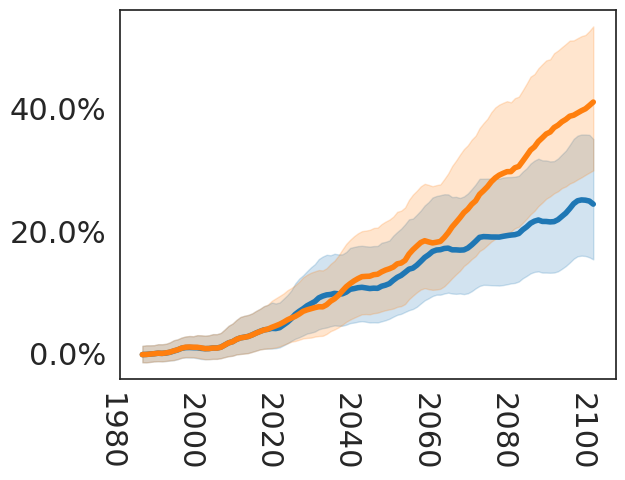

Maximum for function calculate_juvenile_growth polar_cod - 7.500 growth rate:  1.543
                    q5       q95      mean proper_time
time_bin                                              
[1979, 1980)  0.473686  0.501950  0.487032  1980-06-15
[1980, 1981)  0.473570  0.503304  0.487190  1981-06-15
[1981, 1982)  0.473101  0.497599  0.483686  1982-06-15
[1982, 1983)  0.473145  0.497798  0.483891  1983-06-15
Created figure Figures/habitat_suitability_Northern Bering - Chukchi Seas_polar_cod.png


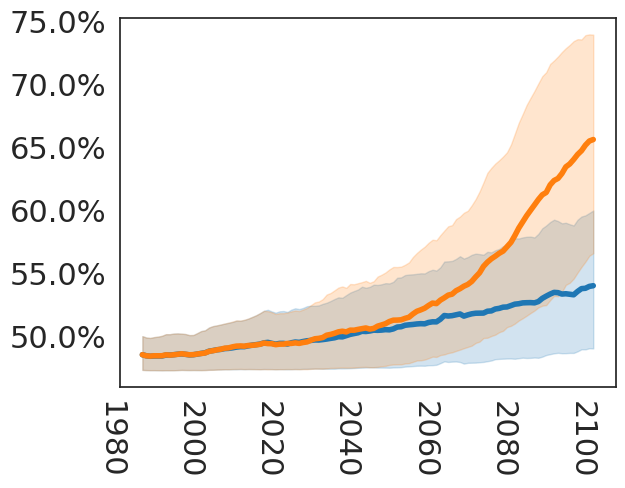

Maximum for function calculate_juvenile_growth walleye_pollock - 13.100 growth rate:  2.979
                    q5       q95      mean proper_time
time_bin                                              
[1979, 1980)  0.049413  0.063814  0.055771  1980-06-15
[1980, 1981)  0.049413  0.065628  0.056444  1981-06-15
[1981, 1982)  0.049220  0.061923  0.054497  1982-06-15
[1982, 1983)  0.049221  0.061441  0.054323  1983-06-15
Created figure Figures/habitat_suitability_Northern Bering - Chukchi Seas_walleye_pollock.png


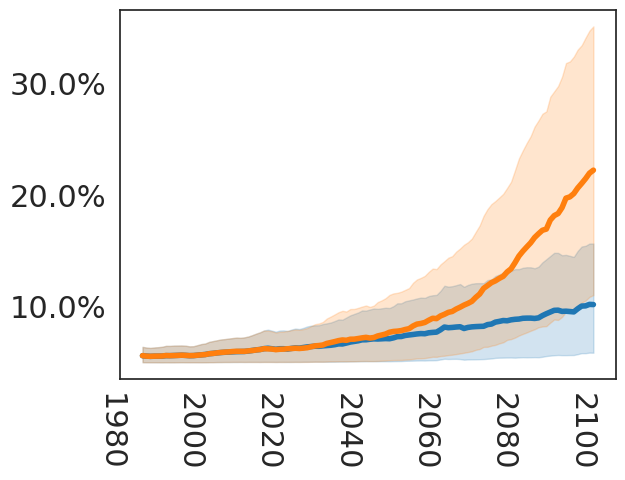

In [5]:
def plot_habitat_suitability(df_habitat_245, df_habitat_585, specie):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
    fig, ax = plt.subplots()
    sns.set_palette("tab10")

    alpha = 0.2
    tickfontsize = 22

    # SSP245 habitat suitability
    ax.fill_between(
        df_habitat_245["proper_time"],
        df_habitat_245["q5"].rolling(rolling_mean_years).mean(),
        df_habitat_245["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:blue",
    )

    ax.plot(
        df_habitat_245["proper_time"],
        df_habitat_245["mean"].rolling(rolling_mean_years).mean(),
        color="tab:blue",
        alpha=1.0,
        linewidth=4,
    )

    # SSP585 growth/survival
    ax.fill_between(
        df_habitat_585["proper_time"],
        df_habitat_585["q5"].rolling(rolling_mean_years).mean(),
        df_habitat_585["q95"].rolling(rolling_mean_years).mean(),
        alpha=alpha,
        color="tab:orange",
    )

    ax.plot(
        df_habitat_585["proper_time"],
        df_habitat_585["mean"].rolling(rolling_mean_years).mean(),
        color="tab:orange",
        alpha=1.0,
        linewidth=4,
    )

    ax.tick_params(labelsize=tickfontsize)
    ax.set_ylabel("")  # "kJm$^{-2}$", fontsize=24)
    ylabels = ["{:,.1%}".format(y) for y in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    fig.canvas.draw()

    # Before you can edit and rotate the labels you have to draw them
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-90, ha="right", fontsize=18)
    ax.tick_params(labelsize=tickfontsize)

    if not os.path.exists("Figures"):
        os.makedirs("Figures")
    plotfile = "Figures/habitat_suitability_{}_{}.png".format(LME, specie)
    print(f"Created figure {plotfile}")

    plt.savefig(plotfile, dpi=300, bbox_inches="tight")
    plt.show()


import math
from operator import itemgetter

for LME, species in zip(LMES, SPECIES_PER_LME):
    for specie in species:
        # Find maximum of calculate_juvenile_growth at all temperatures. This is used to normalize the data
        # found earlier. For egg survival, the maximum survival will always be 100 so we use that.
        temperature_range = list(np.arange(-2, 30, 0.1))

        result = max(
            ((e, calculate_juvenile_growth(e, specie)) for e in temperature_range),
            key=itemgetter(1),
        )
        print(
            f"Maximum for function calculate_juvenile_growth {specie} - {result[0]:3.3f} growth rate:  {result[1]:3.3f}"
        )

        #   print(dfs_all_seasons.keys())

        df_winter_245 = dfs_all_seasons[f"egg_winter_{specie}_ssp245_{LME}"]
        df_winter_585 = dfs_all_seasons[f"egg_winter_{specie}_ssp585_{LME}"]
        df_spring_245 = dfs_all_seasons[f"juvenile_spring_{specie}_ssp245_{LME}"]
        df_spring_585 = dfs_all_seasons[f"juvenile_spring_{specie}_ssp585_{LME}"]
        df_habitat_245 = df_spring_245
        df_habitat_585 = df_spring_585

        for k in ["q5", "q95", "mean"]:
            df_winter_245[k] = (
                dfs_all_seasons[f"egg_winter_{specie}_ssp245_{LME}"][k] / 100.0
            )
            df_winter_585[k] = (
                dfs_all_seasons[f"egg_winter_{specie}_ssp585_{LME}"][k] / 100.0
            )

            df_spring_245[k] = dfs_all_seasons[
                f"juvenile_spring_{specie}_ssp245_{LME}"
            ][k] / float(result[1])
            df_spring_585[k] = dfs_all_seasons[
                f"juvenile_spring_{specie}_ssp585_{LME}"
            ][k] / float(result[1])

            df_habitat_245[k] = df_spring_245[k] * df_winter_245[k]
            df_habitat_585[k] = df_spring_585[k] * df_winter_585[k]

        print(f"{df_habitat_245.head(4)}")

        plot_habitat_suitability(df_habitat_245, df_habitat_585, specie)

In [6]:
SPECIES_PER_LME

[['polar_cod', 'atlantic_cod'], ['polar_cod', 'walleye_pollock']]